# Projektarbeit ”Machine Learning“

*Anastasia Chernysheva, Patrice Korinth*

## Inhaltsverzeichnis
* [Klassifikation des Systemzustands](#chapter1)
    * [Libraries Import](#section_1_1)
    * [Datensatz Analyse](#section_1_2)
    * [Preprocessing](#section_1_3)
    * [Train-Test-Split](#section_1_4)
    * [Binäre Klassifikation](#section_1_5)
* [Vorhersage des Eintretens von Störungen](#chapter2)
    * [Datenvorbereitung](#section_2_1)
    * [Klassifikation](#section_2_2)
    * [Bewertung des Modells](#section_2_3)
* [Vorhersage der Dauer von Störungen](#chapter3)
    * [Datenvorbereitung](#section_3_1)
    * [Regression](#section_3_2)
    * [Bewertung des Modells](#section_3_3)
* [Vorhersage der gestörten Komponente](#chapter4)
    * [Datenvorbereitung](#section_4_1)
    * [Multiclass Klassifikation](#section_4_2)
    * [Bewertung des Modells](#section_4_3)
* [Clustering](#chapter5)

## Klassifikation des Systemzustands <a class="anchor" id="chapter1"></a>

### Libraries Import  <a class="anchor" id="section_1_1"></a>

In [4]:
#Daten Bearbeitung
import pandas as pd
import numpy as np

#Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

#Machine Leaning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

### Datensatz Analyse <a class="anchor" id="section_1_2"></a>

**Einlesen des Datensatzes** <a class="anchor" id="subsection_1_1_1"></a>

In [5]:
# Timestamp str-Format zu datetime umwandeln, um damit Berechnungen durchführen zu können
df = pd.read_csv("dataset_train.csv", index_col='timestamp', parse_dates=["timestamp"])

In [6]:
df.tail()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Flowmeter,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,gpsLong,gpsLat,gpsSpeed,gpsQuality
timestamp,,,,,,,,,,,,,,,,,,,,
2022-06-02 15:49:49,-0.010,8.444,8.204,-0.032,1.466,63.200,19.227156,0.005,1,0,1,1,0,0,0,0,0.0,0.0,0,0
2022-06-02 15:49:50,-0.010,8.442,8.204,-0.034,1.466,63.200,19.217813,0.005,1,0,1,1,0,0,0,0,0.0,0.0,0,0
2022-06-02 15:49:51,-0.010,8.438,8.202,-0.032,1.464,63.225,19.217813,0.005,1,0,1,1,0,0,0,0,0.0,0.0,0,0
2022-06-02 15:49:52,-0.010,8.438,8.202,-0.032,1.466,63.175,19.217813,0.005,1,0,1,1,0,0,0,0,0.0,0.0,0,0
2022-06-02 15:49:53,-0.008,8.438,8.200,-0.032,1.468,63.200,19.227156,0.005,1,0,1,1,0,0,0,0,0.0,0.0,0,0


**Überprüfung von fehlenden Werten** <a class="anchor" id="sub_section_1_1_2"></a>

Fehlende Werte im Datensatz können zu ungenauen und verzerrten Ergebnissen führen, wenn sie bei Vorhersage- und Klassifikationsmodellen verwendet werden. Aus diesem Grund ist es wichtig, den Datensatz auf die Vorhandenheit fehlender Werte zu überprüfen. Außerdem wird auch einen Überblick über die Anzahl der Zeilen und Spalten sowie die Namen der Spalten verschaffen.

In [4]:
print(f"Anzahl Zeilen : {df.shape[0]}, Anzahl Spalten: {df.shape[1]}\n")
print(f'Spaltennamen : \n{df.keys()}\n')
print(f"Spalten mit Anzahl leerer Werte:\n{df.isna().sum()[2:-1]}")

Anzahl Zeilen : 10773588, Anzahl Spalten: 20

Spaltennamen : 
Index(['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature',
       'Flowmeter', 'Motor_current', 'COMP', 'DV_eletric', 'Towers', 'MPG',
       'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses', 'gpsLong',
       'gpsLat', 'gpsSpeed', 'gpsQuality'],
      dtype='object')

Spalten mit Anzahl leerer Werte:
H1                 0
DV_pressure        0
Reservoirs         0
Oil_temperature    0
Flowmeter          0
Motor_current      0
COMP               0
DV_eletric         0
Towers             0
MPG                0
LPS                0
Pressure_switch    0
Oil_level          0
Caudal_impulses    0
gpsLong            0
gpsLat             0
gpsSpeed           0
dtype: int64


Im Preprocessing sind werden die Daten je nach Datentyp in der Regel anders verarbeitet, deswegen werden die Variationen einzelner Features ausgegeben. Die Daten des Datensatzes sind in zwei Kategorien einzuteilen: qualitative und quantitative Daten.

In [5]:
print('Wertvariationen:')
for names in df.keys():
    print(f'{names}: {df[names].nunique()}')

Wertvariationen:
TP2: 5440
TP3: 5173
H1: 5198
DV_pressure: 3712
Reservoirs: 317
Oil_temperature: 3165
Flowmeter: 1911
Motor_current: 3196
COMP: 2
DV_eletric: 2
Towers: 2
MPG: 2
LPS: 2
Pressure_switch: 1
Oil_level: 2
Caudal_impulses: 2
gpsLong: 13187
gpsLat: 1567
gpsSpeed: 147
gpsQuality: 2


**Visualisierung der einzelnen Graphen** <a class="anchor" id="sub_section_1_1_2"></a>

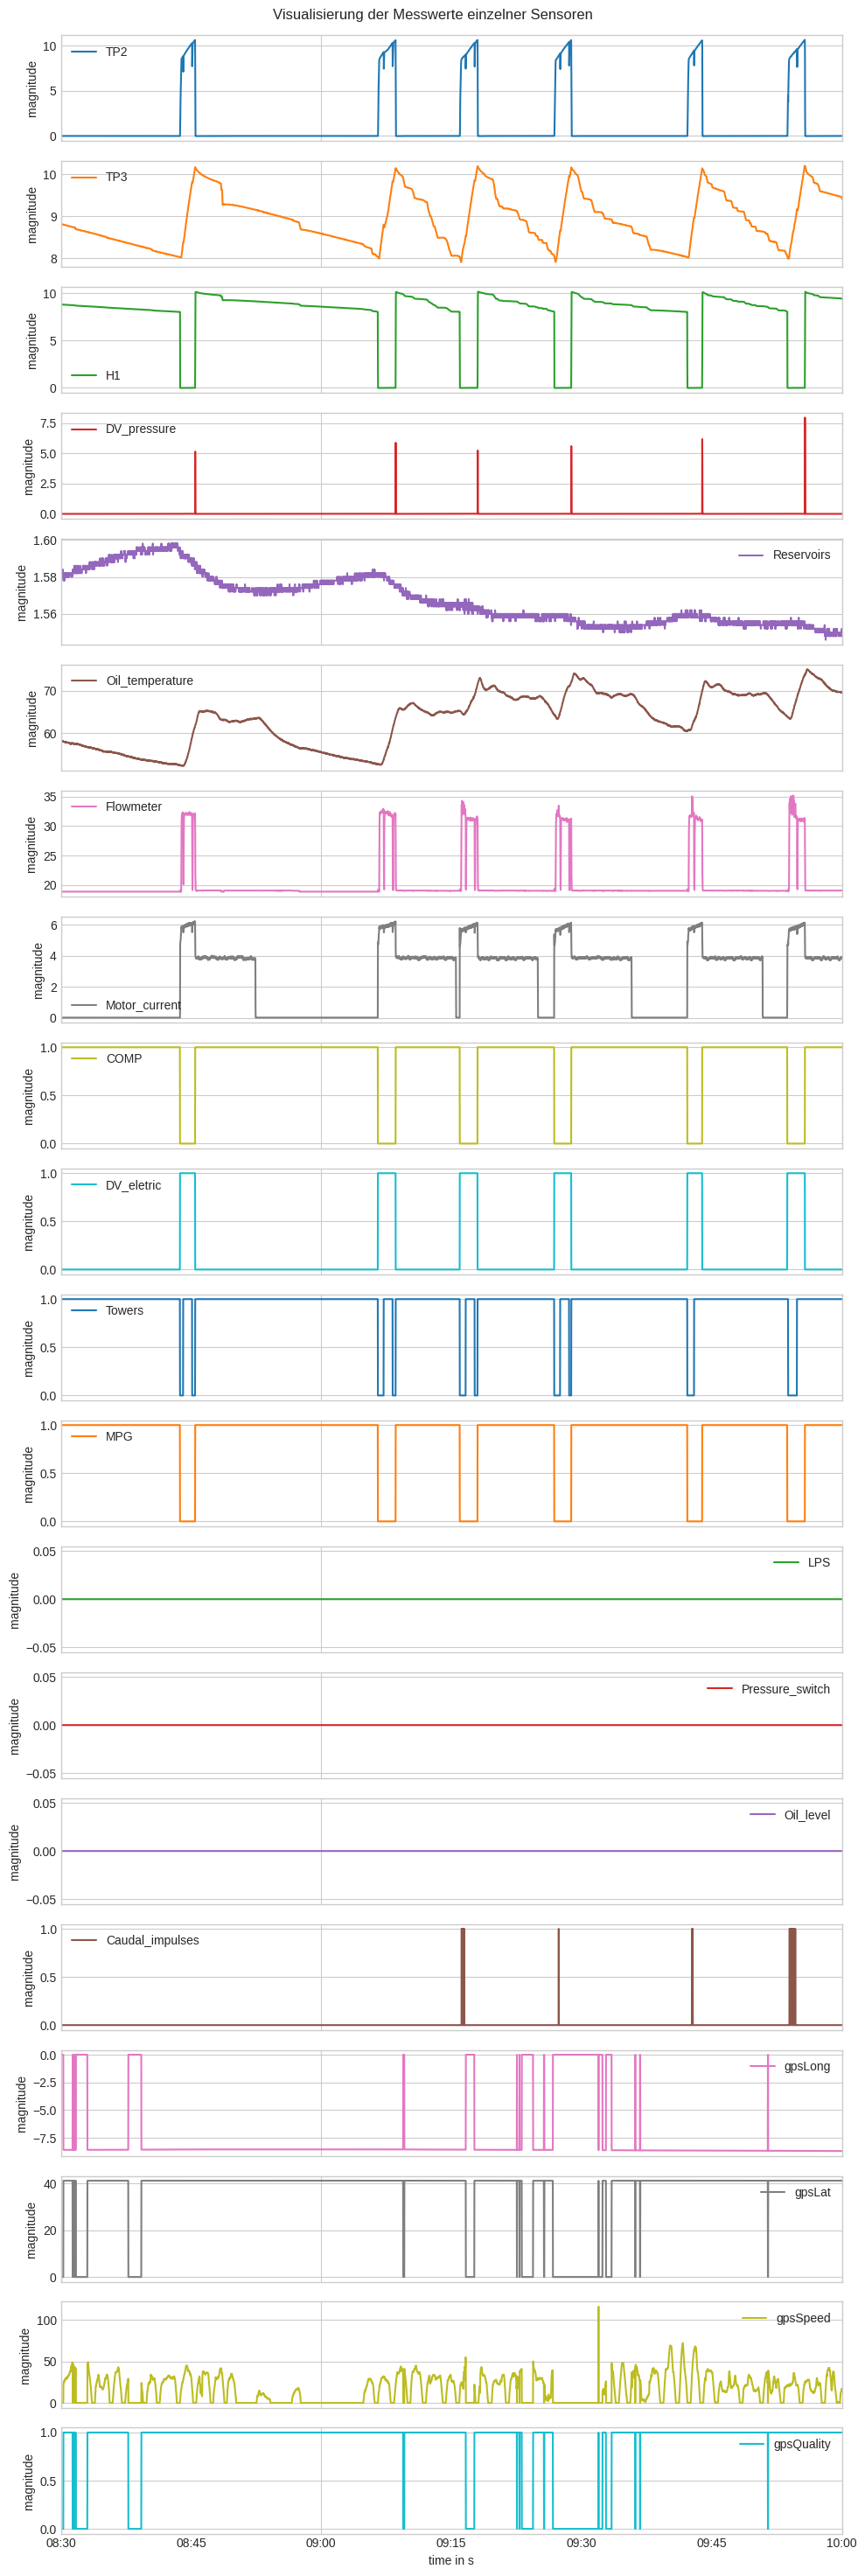

In [349]:
df["2022-01-01 08:30:00":"2022-01-01 10:00:00"].asfreq('S').plot(
    title="Visualisierung der Messwerte einzelner Sensoren",
    subplots=True,
    figsize=(10, 30),
    xlabel="time in s",
    ylabel="magnitude"
    )

plt.tight_layout()
plt.subplots_adjust(top=0.97)

**Varianz der Werte** <a class="anchor" id="sub_section_1_1_4"></a>

In [350]:
df.var().sort_values(ascending=False)

gpsLat             4.240528e+02
gpsSpeed           1.326694e+02
Oil_temperature    2.898586e+01
gpsLong            1.864335e+01
Flowmeter          1.401460e+01
TP2                9.457443e+00
H1                 9.311331e+00
Motor_current      4.810922e+00
TP3                4.909749e-01
gpsQuality         2.499410e-01
DV_eletric         1.131841e-01
MPG                1.131799e-01
COMP               1.131794e-01
Towers             6.097472e-02
DV_pressure        2.209887e-02
Reservoirs         8.129436e-03
LPS                6.241925e-03
Caudal_impulses    1.486702e-03
Oil_level          2.784587e-07
Pressure_switch    0.000000e+00
dtype: float64

Es ist erkennbar, dass _Pressure_switch_ konstant auf 0 bleibt und _Oil_level_ lediglich eine Varianz von 0.0000002784587 aufweist.
Dies ist auch gut in der Visualisierung erkennbar.
Von daher lässt sich schon jetzt vermuten, dass diese Messungen nicht viel zum Modell beitragen werden. Wobei jedoch die ausschweifenden Werte vom _Oil_level_ ein Indiz für einen Schaden spielen könnten. Deswegen müssen noch weitere Analysen diesbezüglich erfolgen.

**Korrelationsmatrix** <a class="anchor" id="sub_section_1_1_5"></a>

Es wird eine Korrealationsmatrix erstellt, um sich einen Überblick über die wichtigen Features in dem Datensatz zu verschaffen. 

In [409]:
crrmtx = df.corr()

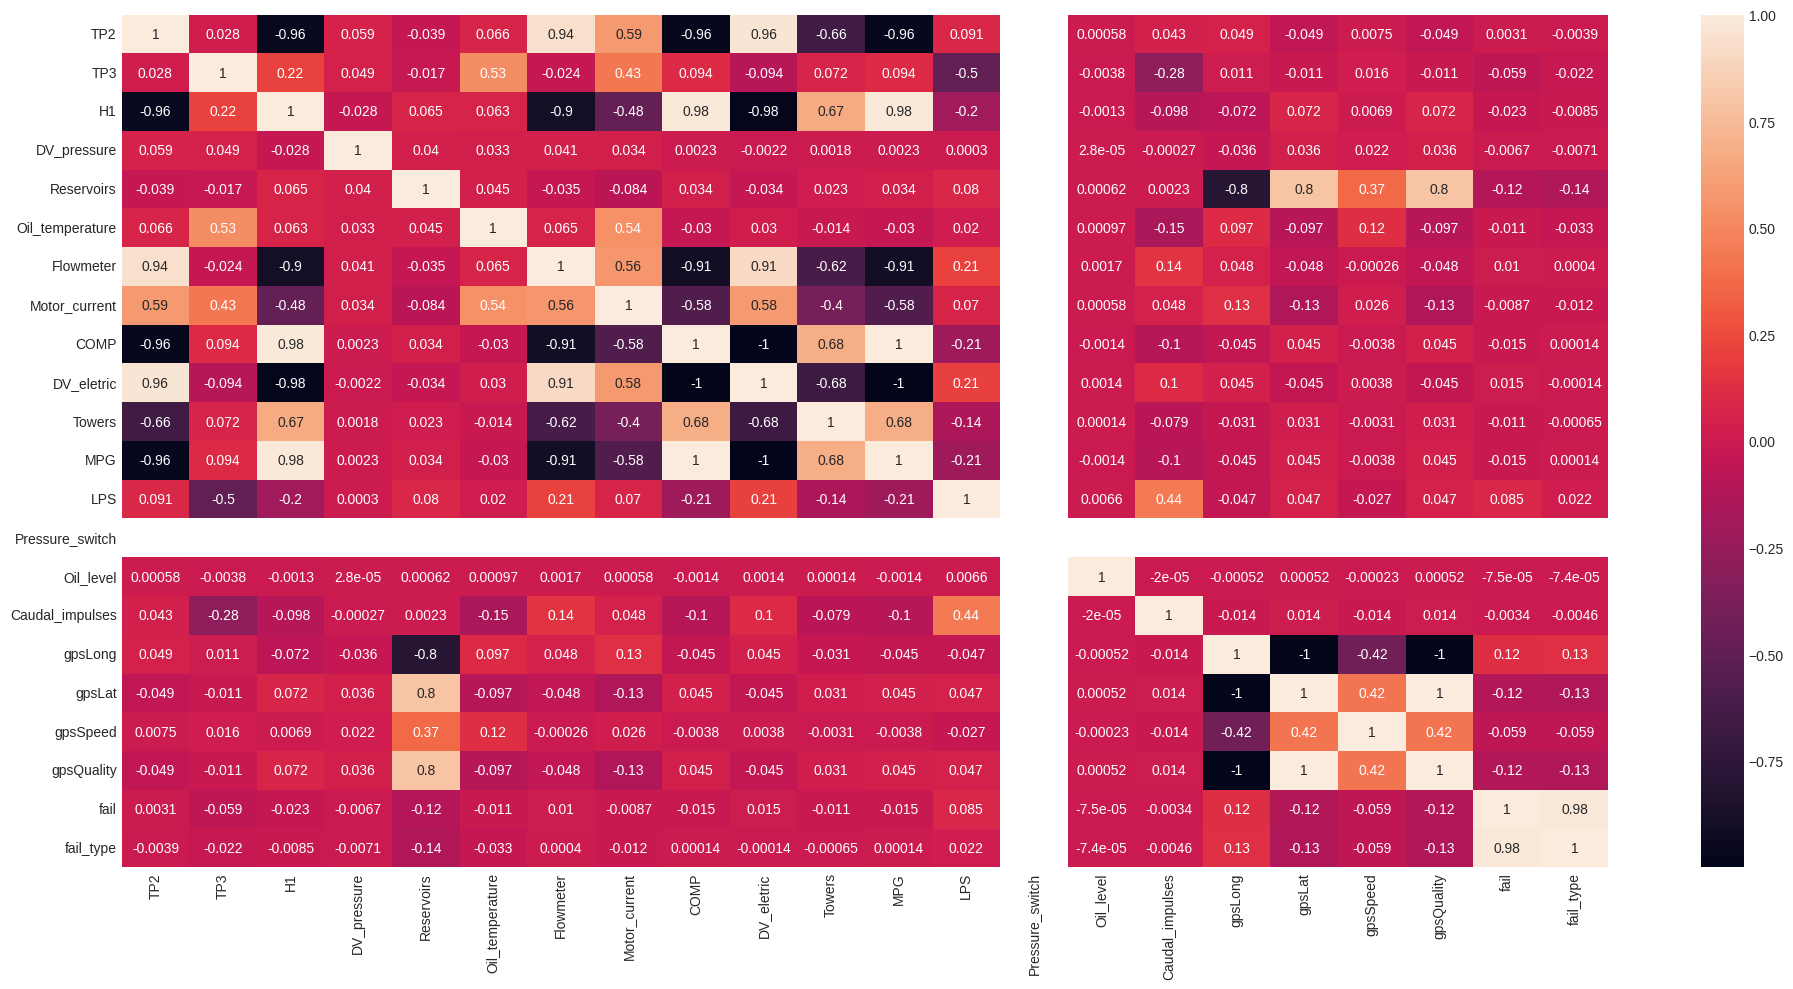

In [410]:
plt.figure(figsize=(20, 10))
sns.heatmap(crrmtx, annot=True)
plt.tight_layout()
plt.show()

Nach Überprüfung der Korrelationsmatrix kann man schlussfolgern, dass das Feature _Pressure_switch_, wie schon oben vermutet, keine signifikante Auswirkung auf den Datensatz hat und somit entfernt werden kann. Außerdem offenbart die Matrix
komplexe Wechselwirkungen zwischen den verschiedenen Features. Es kann beobachtet werden, dass eine positive Korrelation zwischen den Features _Flowmeter_, _DV-electric_ und _TP2_ besteht, während eine negative Korrelation zu den Features _H1_, _COMP_ und _MPG_ vorliegt. Dies zeigt, dass eine Erhöhung der Werte von Features zu einer synchronen Abnahme der anderen Featurewerte führt.<br>Sowohl positive als auch negative Korrelationen kann das Modell verwirren und somit dessen Leistung beeinträchtigen.In weiteren Schritten werden diese Wechselbeziehungen statistisch analysiert, um diese Wechselbeziehungen untereinander zu verstehen, um ein besseres Feature Engineering zu ermöglichen. 

**Label für Störung und Art der Störung hinzufügen** <a class="anchor" id="sub_section_1_1_6"></a>

In der Dokumentation werden folgende Störungen beschrieben:

|Nr. 	  |  Type 	 |  Component | 	Start 	   |     End 	   |      # Exs.|
|---------|--------------|------------|----------------|---------------|--------|
|Failure 1 |	Air Leak |	Clients   |	28-02-22 21:53 |01-03-22 02:00 |	14 820|
|Failure 2 |	Air Leak |	Air Dryer |	23-03-22 14:54 |23-03-22 15:24 |	1 800|
|Failure 3 |	Oil Leak |	Compressor| 30-05-22 12:00 |02-06-22 06:18 |	281 800|

Aufgrund der ungleichmäßigen Verteilung der Störungsdaten, liegt eine Überrepräsentation der größten Klasse vor, welche durch die letzte Störung definiert wird. Darüber hinaus ist die letzte Störung nahezu am Ende des Datensatzes platziert, was zu Problemen bei der Trennung des Datensatzes in Trainings- und Testdaten führen kann, da eine zufällige Separation die Zeitstruktur, welche für die prägnanten Merkmale bedeutsam ist, beeinträchtigen würde.

In [11]:
# Dicts erstellen mit relevanten Angaben zu den Störungen
fail1 = {
    "start":pd.to_datetime("2022-02-28 21:53:00"),
    "end":pd.to_datetime("2022-03-01 02:00:00"),
    "component":1
}

fail2 = {
    "start":pd.to_datetime("2022-03-23 14:54:00"),
    "end":pd.to_datetime("2022-03-23 15:24:00"),
    "component":2
}

fail3 = {
    "start":pd.to_datetime("2022-05-30 12:00:00"),
    "end":pd.to_datetime("2022-06-02 06:18:00"),
    "component":3
}

In [12]:
#Der Transformer dient dazu, die entsprechenden Label je nach Zeitpunkt auf dem Datensatz anzuwenden 
class LabelTagger(BaseEstimator, TransformerMixin):
    def fit(self, X):
        return self 
    def transform(self, X):
        #Die Informationen über die Störung und die Art der Störung werden getrennt in zwei Spalten gespeichert
        X[['fail', 'fail_type']] = 0
        for i in range(1,4):
            #Dicts mit den Information über die jeweiligen Störungen
            fails = globals()["fail%s" % i]
            #Eine Störung wird mit einer 1 deklariert, während eine Null für das Fehlen einer Störung steht
            X.loc[fails["start"]:fails["end"], 'fail'] = 1
            #Die Art der Störung wird durch Zahlen von 1 bis 3 gekennzeichnet
            X.loc[fails["start"]:fails["end"], 'fail_type'] = fails['component']
        return X

In [13]:
#Label zum Datensatz hinzufügen
df = LabelTagger().transform(df)

**Analyse der Klassenverteilung** <a class="anchor" id="sub_section_1_1_7"></a>

In [6]:
# Berechnen die Anzahl der Störungen pro Störungsart
def failInfo(df):
    s_fail = df[df["fail"] == 1].shape[0]
    s_fail_clie = df[df["fail_type"] == 1].shape[0]
    s_fail_aird = df[df["fail_type"] == 2].shape[0]
    s_fail_comp = df[df["fail_type"] == 3].shape[0]

    print(
        f"""Anzahl der Samples für den jeweiligen Fehlertyp: 
        \nAllgemein: {s_fail}
        \nClients: {s_fail_clie}
        \nAirdryer: {s_fail_aird}
        \nCompressor: {s_fail_comp}"""
        )
    

In [7]:
failInfo(df_fails)

Anzahl der Samples für den jeweiligen Fehlertyp: 
        
Allgemein: 212106
        
Clients: 14821
        
Airdryer: 1801
        
Compressor: 195484


Es besteht eine Diskrepanz zwischen den Fehlerdaten des Compressors und den Informationen in der Dokumentation.

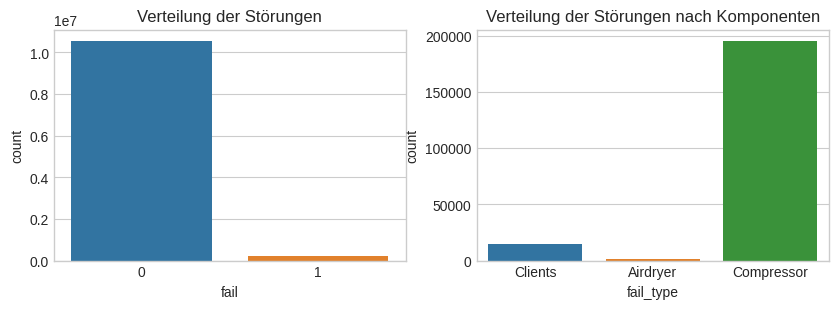

In [1361]:
#Plot die Verteilung zwischen der Klasse mit und ohne Fehler
fig, axes = plt.subplots(1, 2, figsize=[10,3])
sns.countplot(x='fail', data=df_fails, ax=axes[0], ).set_title('Verteilung der Störungen')
sns.countplot(x='fail_type', data=df_fails[-(df_fails.fail_type == 0)], ax=axes[1]).set_title('Verteilung der Störungen nach Komponenten');

Es ist klar erkennbar, dass sowohl die Störungen, als auch die Art der Störungen, wie bereits vermutet, stark unbalanciert sind, weswegen der Datensatz im späterem Verlauf balanciert werden muss, da es sonst zu Verzerrungen in der Vorhersage kommen kann. Infolgedessen werden bei der Modellklassifizierung Maßnahmen, beispielsweise *class weight*, angewendet.

### Preprocessing <a class="anchor" id="section_1_3"></a>

Um die Menge an Daten in dem umfangreichen Datensatz zu reduzieren und wichtige Informationen beizubehalten, wird die Technik des  *SlidingWindow* angewendet. Hierbei werden die Informationen aus einer bestimmten Anzahl von Zeilen berechnet, um einen Mittelwert zu erhalten. Dies verringert die Größe des Datensatzes und erleichtert das Modelltraining. Eine Klasse namens `OutlierImputer` wird ebenfalls erstellt, um NaN-Werte mit den letzten vorhandenen Werten zu ersetzen und somit die Zeitreihenstruktur zu erhalten. Obwohl der aktuelle Datensatz keine `NaN`-Werte enthält, ist es wichtig, dass das Modell auch für unbekannte Daten anwendbar ist. <br>Die Reihenfolge der Transformer spielt eine bedeutende Rolle, da die angewendete Methode _rolling_ in der `SlidingWindow`-Klasse nicht mit `NaN`-Werten umgehen kann, da diese nicht nummerisch sind. Infolgedessen müssen die Daten zunächst mit `OutlierImputer`und danach mit `SlidingWindow` transformiert werden. 

In [14]:
#Transformer, um NaN-Werte zu füllen
class OutlierImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self 
    #Imputiere alle fehlenden Werte von X
    def transform(self, X, y=None):
        X = X.astype(float)
        # Befülle die Leeren Werte mit den letzten vorhandenen Werten, um Bezug zur Zeitkontinuität zu bewahren
        return X.fillna(method='bfill')

In [15]:
#Transformer, um die Datenmenge zu begrenzen
class SlidingWindow(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=50, step_size=1):
        self.window_size = window_size
        self.step_size = step_size
        
    def fit(self, X):
        return self

    def transform(self, X):
        #Erstelle ein Fenster, das über die Daten gleitet in n Schritten und für die angegebene Fenstergröße den 
        #Mittelwert berechnet
        X_window = X.rolling(window=self.window_size, step = self.step_size).mean()
        return X_window

**Feature Engineering** <a class="anchor" id="sub_section_1_3_1"></a>

Der Datensatz verfügt zwar zwei unterschiedliche Datentypen, jedoch werden sie zusammen verarbeitet. Die Daten werden standardisiert, um eine einheitliche Skalierung aller Funktionen zu gewährleisten. Dieser Schritt ist wichtig, da es das Anwenden der Technik der PCA (Principal Component Analysis) ermöglicht, die dazu dient, die Dimensionen der Daten zu reduzieren. Die PCA transformiert komplexe Daten in eine einfach interpretierbare Form, indem sie neue Merkmale berechnet, die eine hohe Variabilität aufweisen. Eine nicht standardisierte Vorgehensweise könnte dazu führen, dass weniger bedeutsame Daten überbewertet werden, was zu einer Verzerrung der Merkmalsberechnung führt.

In [16]:
#Erstelle Preprocessor Pipeline
preprocessor = Pipeline([('scl', StandardScaler()), ('pca', PCA())])

Die Daten sollen nun statistisch analysiert werden, um die bestmögliche Auswahl an Features für das Modelltraining zu treffen.

In [17]:
sw  = SlidingWindow(window_size=5, step_size=3600)
df_plot = sw.transform(df).dropna()

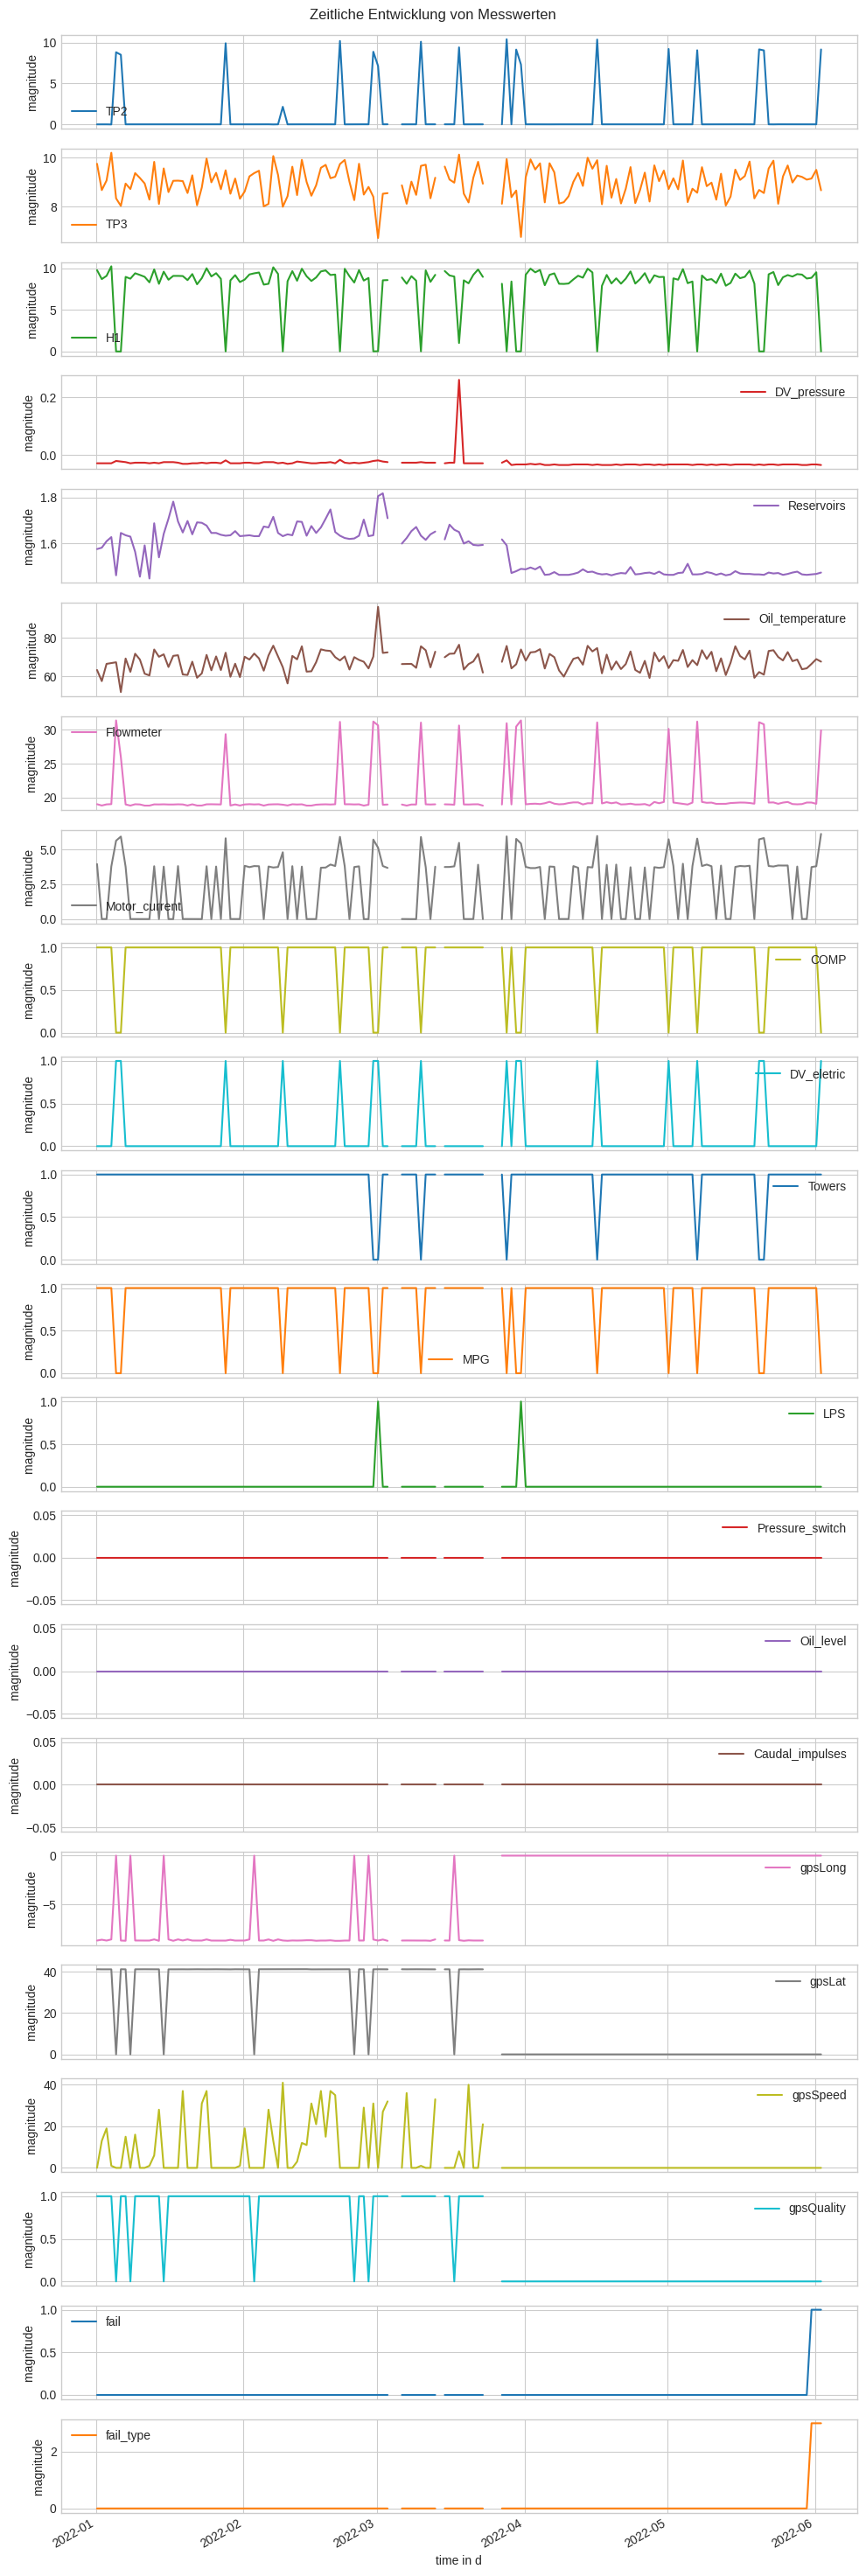

In [23]:
df.asfreq('D').plot(
    title="Zeitliche Entwicklung von Messwerten",
    subplots=True,
    figsize=(10, 30),
    xlabel="time in d",
    ylabel="magnitude"
    )

plt.tight_layout()
plt.subplots_adjust(top=0.97)

Es zeigt sich, dass die Features _Oil_level_ und _Caudal_impulses_ konstant sind und somit entfernt werden können, da sie für den Datensatz keine bedeutenden Informationen liefern. Ein wichtiges Feature könnte _LPS_ für die Identifizierung von Störungen und der Klassifizierung der Art der Störung sein, aufgrund der beiden Ausschläge, die bei jeder Störung auftreten. Die bereits untersuchten Korrelationen werden hier erneut ersichtlich. Um unter diesen für das Modell bedeutsamsten Features zu bestimmen, wird die Random Forest-Klassifikation eingesetzt.<br>Ein interessante Beobachtung ist, dass das Feature "Reservoirs" über die Zeit abnimmt, was eine Erklärung für die letzte Störung liefern könnte. Ein weiteres hervorstechendes Feature ist _DV_pressure_, welches im nachfolgenden Schritt näher untersucht wird.

In [1362]:
#Visualisierung der Störungen in Form eines Liniendiagramms und des Zeitpunktes +/- 2 Stunden dazwischen
def plotError(df, fail, hours, fail3=False):
    fig, ax = plt.subplots(df.shape[1], figsize=(10, 30), sharex=True)
    #Da die dritte Störung über mehrere Tage besteht, wird Endzeitpunkt auf Startzeit+2 gesetzt,
    #um den vorherigen Zeitpunkt genauer anschauen zu können
    if fail3:
        #Neuer Endzeitpunkt wird festgelegt
        end = fail["start"]+pd.Timedelta(hours=2)
        #Iteriere über die Datensatzspalten und visualisiere pro Spalte den ungestörten Betrieb sowie die Störung
        for i, column in enumerate(df.columns):
            ax[i].plot(df[fail["start"]-pd.Timedelta(hours=hours):end]
                       .asfreq('S')[column], '-', color='green', alpha=0.5, label="Betrieb")
            #Die Störung wird gehighlited, um sie zwischen den normalen Betrieb zu unterscheiden
            ax[i].plot(df[fail["start"]:end].asfreq('S')[column], '-', color="red", alpha=0.9, label="Error")
            ax[i].set_title(column) 
            ax[i].legend(loc="upper right", frameon=True, framealpha=0.5)
    #Störungen, die nicht über Tage gehen, um zu schauen wie der Betrieb nach dem Beheben der Störung aussieht
    else:
        #Iteriere über die Datensatzspalten und visualisiere pro Spalte den ungestörten Betrieb sowie die Störung
        for i, column in enumerate(df.columns):
            ax[i].plot(df[fail["start"]-pd.Timedelta(hours=hours):fail["end"]+pd.Timedelta(hours=hours)]
                       .asfreq('S')[column], '-', color='green', alpha=0.5, label="Betrieb")
            #Die Störung wird gehighlighted, um sie zwischen dem normalen Betrieb zu unterscheiden
            ax[i].plot(df[fail["start"]:fail["end"]].asfreq('S')[column], '-', color="red", alpha=0.9, label="Error")
            ax[i].set_title(column)
            ax[i].legend(loc='upper right', framealpha=0.5, frameon=True)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.97)
    plt.show()

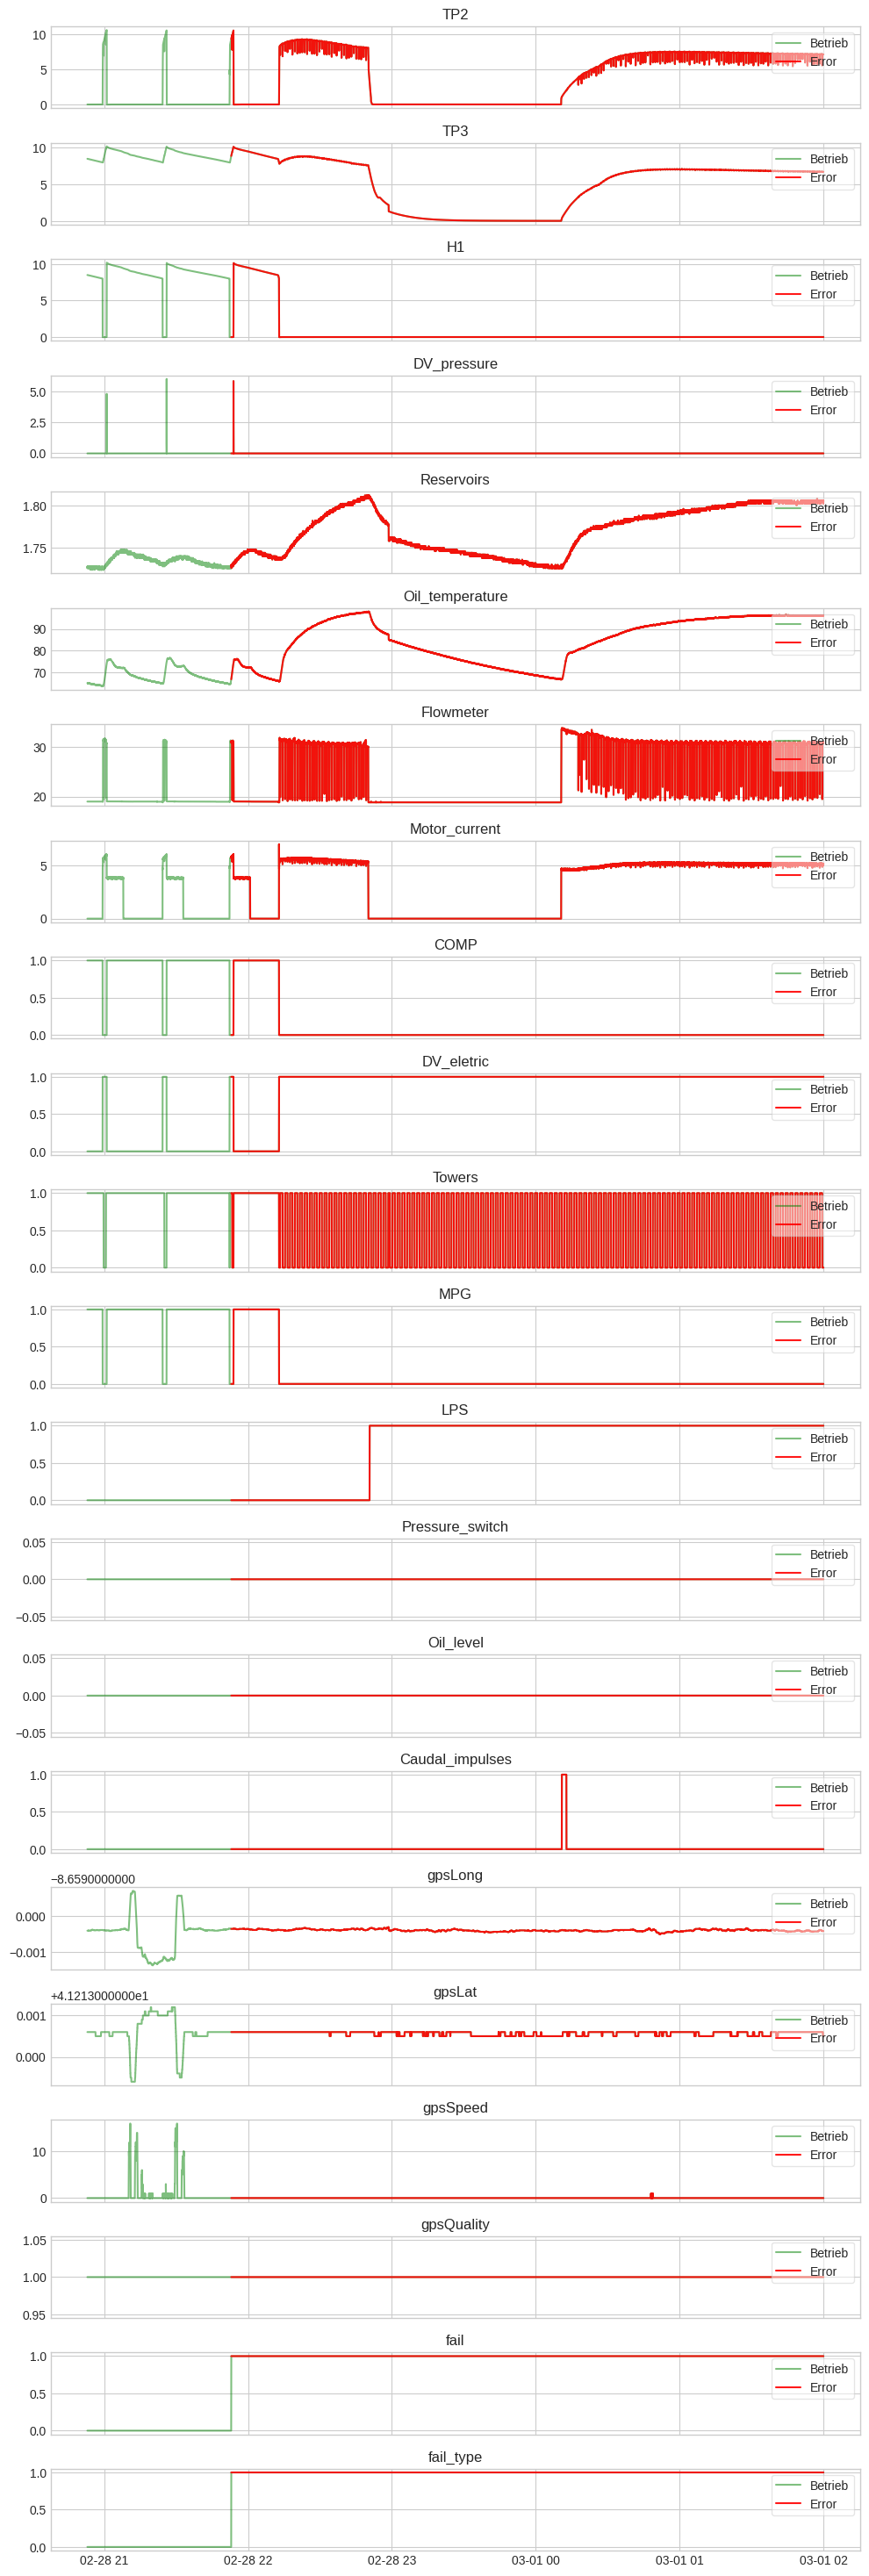

In [1712]:
plotError(df, fail1, 1)

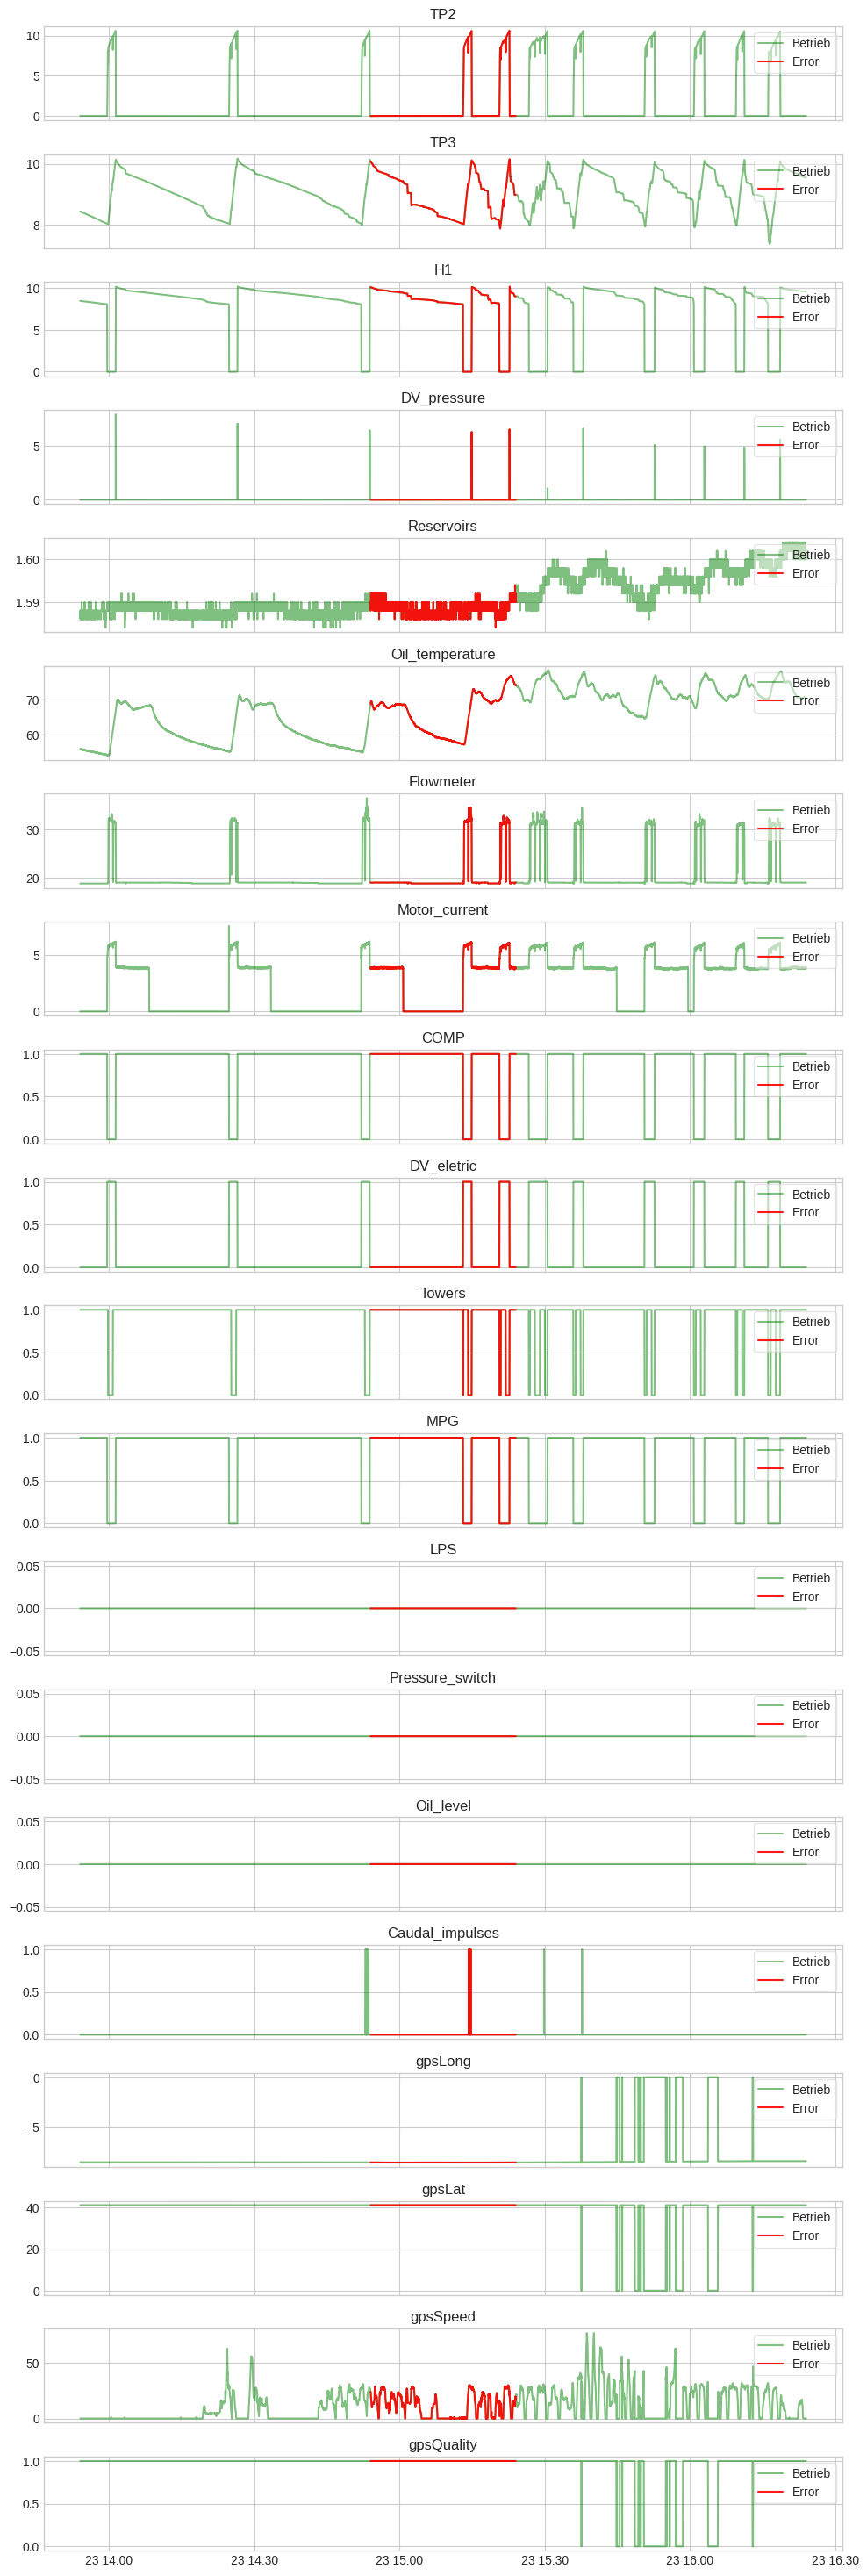

In [1371]:
plotError(df, fail2, 1)

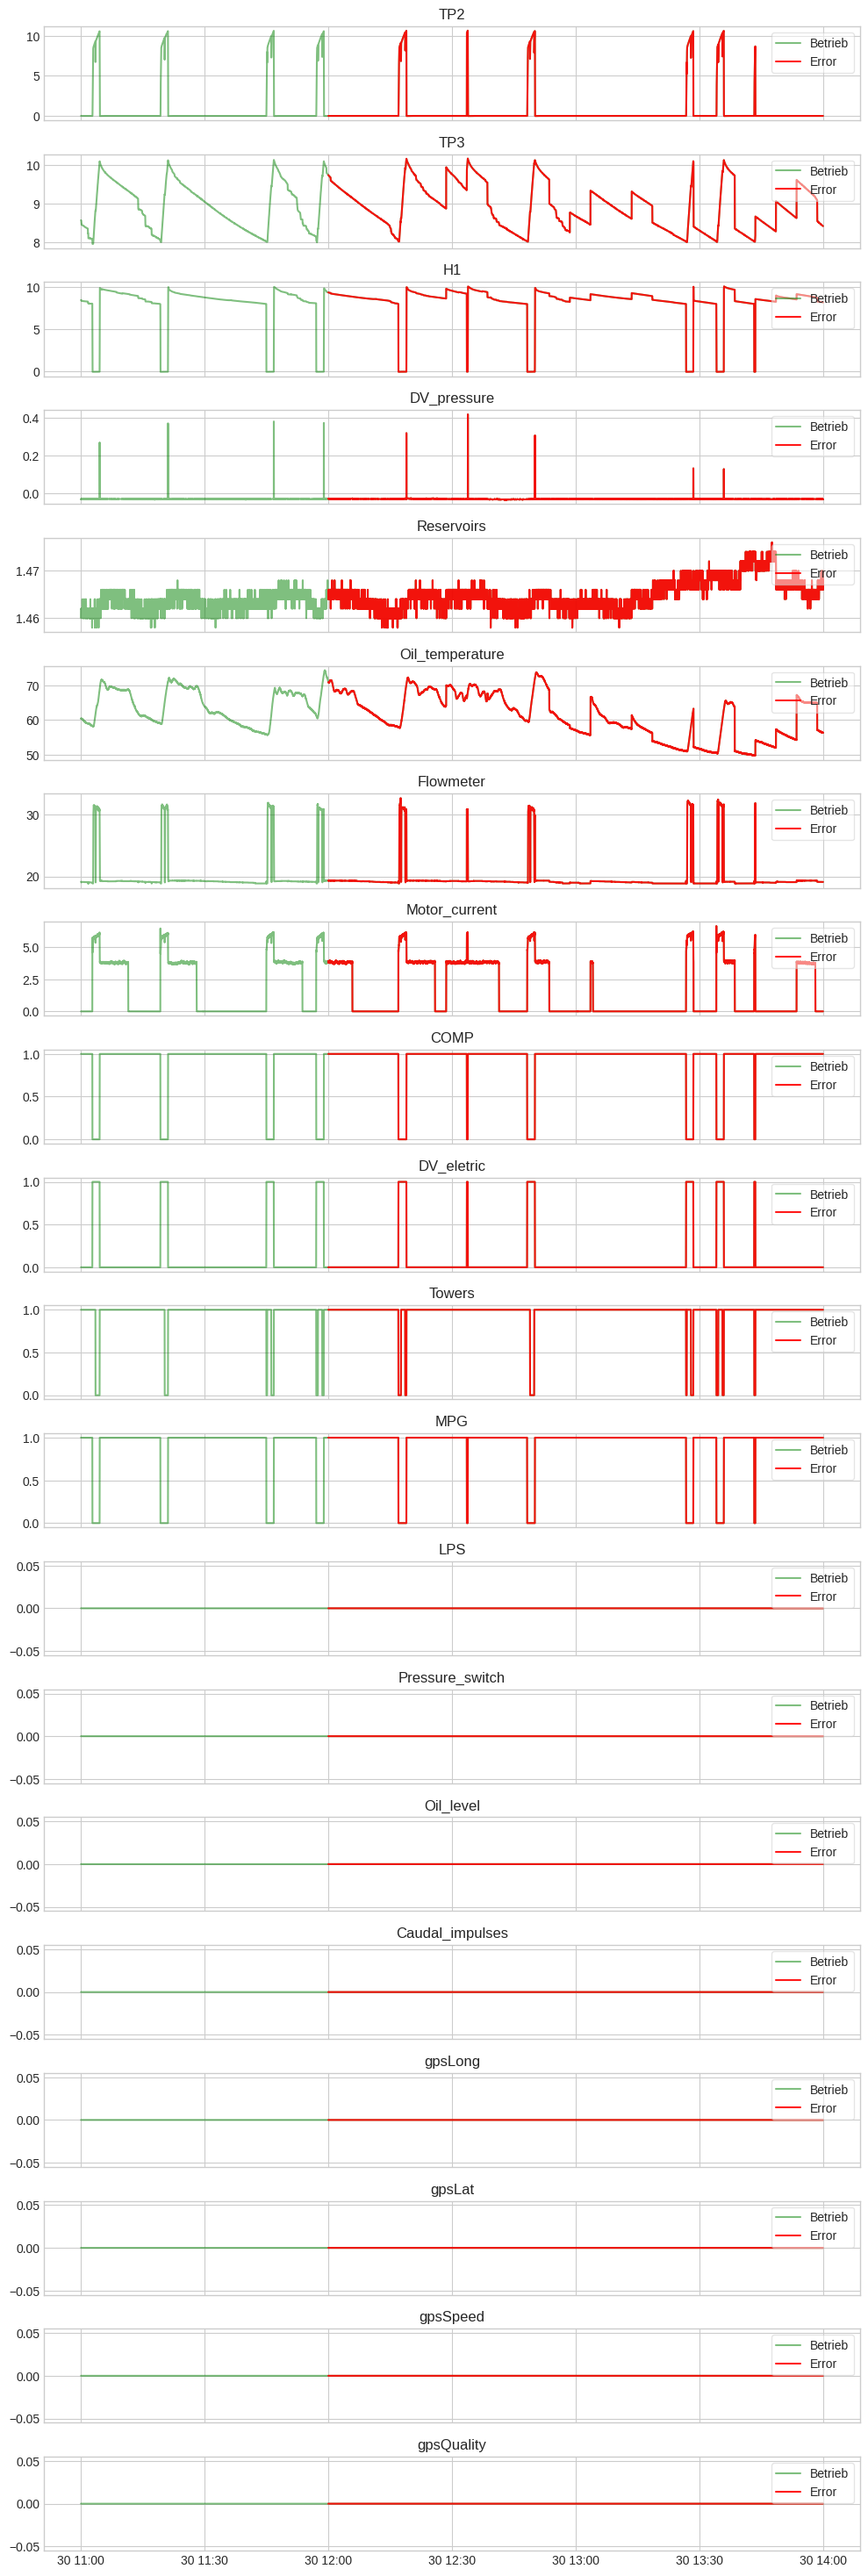

In [1372]:
plotError(df, fail3, 1, fail3=True)

Man kann beobachten, dass die GPS Daten bei der dritten Störung immer konstant sind und das schon eine ganze Weile
vor dem Error. Diese Daten werden bei der Klassifikation einer Störung entfernt, da sie zum einem miteinander korrelieren und für die Klassifikation der Störung keine Informationen bringen, wenn man berücksichtigt, dass Störung 3 die größte Datenmenge aufweist. Ein weiterer Aspekt, ist die _LPS_-Komponente, die nur zwei mal im ganzen Zeitintervall ausschlägt. Es wäre eine Möglichkeit diese, sowie die GPS-Daten, für die Klassifikation der Störungen zu verwenden. 

### Train-Test-Split <a class="anchor" id="section_1_4"></a>

In [18]:
#Es wird eine Transformationspipeline erstellt, die zunächst wie oben beschrieben, die NaN-Werte ersetzt,
#danach die Informationen zu den Störungen in dem Datensatz einfügt und zum Schluss die Daten reduziert. 
imp = OutlierImputer()
lt  = LabelTagger()
sw  = SlidingWindow()

trans_pipe = Pipeline([('imp', imp), ('sw', sw), ('lt',lt)])

In [53]:
#Datentransformation und Entfernung der NaN-Werte, die im Zuge der rolling-Methode am Anfang entstehen,
#da es noch keine ausreichende Anzahl an Samples gibt, für die ein Mittelwert berechnet werden kann
df_tr = trans_pipe.transform(df).dropna()

#Die Daten werden mithilfe von PCA auf 4 Dimensionen reduziert, und es werden Parameter für das Slidingwindow bestimmt
preprocessor.set_params(pca__n_components=4)
trans_pipe.set_params(sw__window_size=60, sw__step_size=10)

Pipeline(steps=[('imp', OutlierImputer()),
                ('sw', SlidingWindow(step_size=10, window_size=60)),
                ('lt', LabelTagger())])

Da das Modell schon aufgrund seiner umfangreichen Daten zu komplex sein könnte, werden die Features entfernt,
die die höchste Korrelation zueinander haben, sowie die GPS-Daten, da sie das Modell verwirren könnten wie schon,
oben beschrieben.
<br>Um die Daten in Trainings- und Testdaten aufzuteilen, wird die `TimeSeriesSplit`-Klasse verwendet, da diese die Zeitreihenstruktur berücksichtigt und die Daten sequentiell aufteilt. 

In [54]:
drop_list = ['fail', 'fail_type','Pressure_switch', "gpsLong","gpsLat", "gpsSpeed", "gpsQuality",'COMP',
             'Caudal_impulses', 'DV_eletric', "TP2", 'Oil_level', "MPG"]
# TimeSeriesSplit nutzen, um Zeitabfolgen zu bewahren
tms = TimeSeriesSplit(n_splits=2)
#Entferne die nicht benötigten Features und übergebe y nur die Labels
X = df_tr.drop(drop_list, axis=1)
y = df_tr['fail']
#Es wird ein neuer Index erstellt, der die Daten nacheinander separiert
for train_idx, test_idx in tms.split(X):
    X_train, X_test  = X.iloc[train_idx, :], X.iloc[test_idx,:]
    y_train, y_test  = y.iloc[train_idx], y.iloc[test_idx]

In [20]:
print(f'Verteilung der Klassen in y_train \n{y_train.value_counts(normalize=True)}\n{len(y_train)}')
print(f'Verteilung der Klassen im y_test \n{y_test.value_counts(normalize=True)}\n{len(y_test)}');

Verteilung der Klassen in y_train 
0    0.997686
1    0.002314
Name: fail, dtype: float64
718236
Verteilung der Klassen im y_test 
0    0.945566
1    0.054434
Name: fail, dtype: float64
359117


### Binäre Klassifikation  <a class="anchor" id="section_1_5"></a>

**Auswahl von Klassifikationsmodellen** 

Es wurde sich für folgende Klassifikatoren enschieden:
<br>DecisionTreeClassifier: Da sowohl qualitative als auch quantitative Daten vorhanden sind und dieser sich für für binäre und für Multiclass-Klassifikation eignet.
<br>Logistische Regression: Auch diese ist besonders gut für binäre Klassifikationen geeignet, aber auch Multiclass-Klassifikation ist möglich.
<br>Da die Daten hochdimensionalen sind und die Features mehrfach korrelieren, wird zuletzt der RandomForrest ausgewählt. Zusätzlich kann er auch eine Feature Importance liefern, was ihn für die Feature Selection interessant macht.
Alle drei haben die Möglichkeit die Gewichtungen der Klassen anzupassen. 

In [19]:
clfs = {
    'rf': RandomForestClassifier(),
    'dsc'  : DecisionTreeClassifier(),
    'logre': LogisticRegression()
}

**Kreuzvalidierung** <a class="anchor" id="chapter5_2"></a>

Um die bestmöglichen Parameter für die Klassifikatoren zu bestimmen, wird `GridSearch` verwendet. Die Parameter werden im _param_grid_ festgelegt und zusammen mit dem dazugehörigen Klassifizierer an `GridSearch` übegeben. Dieser probiert die Kombination aus allen angegebenen Parametern aus und gibt die beste Kombination aus. 

In [22]:
#Dictionarys, um die besten Werte der GridsearchCV zu speichern
best_scores = {'rf': 0, 'dsc': 0, 'logre':0}
best_params = {'rf': 0, 'dsc': 0, 'logre':0}

In [20]:
# Hyperparameter für GridsearchCV
param_grid = {
    "rf": {'n_estimators':[2, 5, 10],
           'criterion': ["gini", "entropy", "log_loss"],
           'min_samples_split':[10, 50, 100],
           'max_depth':[2, 5, 10],
           'class_weight': ["balanced", None, {0:.1, 1:.9}, {0:.03, 1:.97}, {0:.05, 1:.95}]},
    "dsc":{'criterion':["gini", "entropy", "log_loss"],
           'min_samples_leaf': [10, 100, 500],
           'max_depth':[10, 100, 500],
           'max_features':["sqrt", "log2"],
           'class_weight':["balanced", None, {0:.1, 1:.9}, {0:.03, 1:.97}, {0:.05, 1:.95}]},
    "logre":{'penalty':["l2", 'elasticnet'],
             'C': [1, 5, 10],
             'verbose': [1, 0],
             'class_weight': ["balanced", None, {0:.1, 1:.9}, {0:.02, 1:.98}, {0:.05, 1:.95}]},
    "rfreg":{'n_estimators':[2, 5, 10],
              'max_features': ['auto', 'sqrt'],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 3, 5] }   
    }

In [25]:
#GridsearchCV ist im default auf shuffling=false eingestellt, was sich für die Zeitreihen-Daten eignet
classifier = "logre"
#Da Accuracy nicht geeignet ist, um das Modell richtig zu bewerten, wird die F1-Metrik gewählt. Diese setzt sich 
#aus dem Recall und Precision zusammen und wird von der dominanten Klasse nicht beeinflusst.  
grid = GridSearchCV(clfs[classifier], param_grid[classifier], scoring="f1")

In [ ]:
#Die Daten werden zunächst mit Preprocess transformiert, da es sonst zu einem verzerrten Resultat kommen würde, 
#wenn man die unbearbeiteten Daten mit GridSearch fittet
X_trans = preprocessor.fit_transform(X_train)
grid.fit(X_trans, y_train)

In [27]:
#Die besten Resultate werden im Dictionary gespeichert und visualisiert
best_scores[classifier] = grid.best_score_
best_params[classifier] = grid.best_params_
print(best_params[classifier])
print(best_scores[classifier])

{'C': 1, 'class_weight': {0: 0.1, 1: 0.9}, 'penalty': 'l2', 'verbose': 1}
0.5500498156506858


**Modelltraining** 

In [25]:
#Kreiert eine Klassifikationspipeline, mit dem Imputierer, Preprocessor und dem Klassifikator
def createPipe(clf):
    return Pipeline([("imp", OutlierImputer()),('prc', preprocessor),('clf', clf)])

In [29]:
#Erstellt einen neuen Klassifikator, setzt die besten Resulate aus der GridSearch als Parameter ein und fittet die
#Pipeline
pipe = createPipe(clfs[classifier])
pipe.named_steps["clf"].set_params(**best_params[classifier])
pipe.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.07059D+04    |proj g|=  3.50808D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Pipeline(steps=[('imp', OutlierImputer()),
                ('prc',
                 Pipeline(steps=[('scl', StandardScaler()),
                                 ('pca', PCA(n_components=4))])),
                ('clf',
                 LogisticRegression(C=1, class_weight={0: 0.1, 1: 0.9},
                                    verbose=1))])

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   2.634D-01   2.965D+03
  F =   2965.1070080382960     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


**Bewertung der Modellgüte**

In [33]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
#Ausgabe der Metriken zur Bewertung der Güte des Modells 
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)
print("-----Training Metriken----------")
print('Accuracy: ', pipe.score(X_train, y_train))
print('Precision: ', precision_score(y_train, y_pred_train, average = 'macro'))
print('Recall: ', recall_score(y_train, y_pred_train, average = 'macro'))
print('F1: ', f1_score(y_train, y_pred_train, average = 'macro'))
print("-----Test Metriken----------")
print('Accuracy: ', pipe.score(X_test, y_test))
print('Precision: ', precision_score(y_test, y_pred_test, average = 'macro'))
print('Recall: ', recall_score(y_test, y_pred_test, average = 'macro'))
print('F1: ', f1_score(y_test, y_pred_test, average = 'macro'))

-----Training Metriken----------
Accuracy:  0.9959623299305521
Precision:  0.6613023056481981
Recall:  0.8391999923341611
F1:  0.7183055609586276
-----Test Metriken----------
Accuracy:  0.9455664866881824
Precision:  0.4727832433440912
Recall:  0.5
F1:  0.4860108832866266


/home/b1fc/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Zwar wird die Accuracy hier angegeben, jedoch wird der Wert nicht soderlich stark gewichtet, da dieser schon einen
hohen Wert erreicht, wenn das Modell zufälligerweise die Werte richtig eingeordnet, besonders wenn der Datensatz stark unbalanciert ist, dies liegt an der hohen Menge der Daten, die innerhalb eines funktionablen Betriebs ermittelt wurden. Erkennbar ist es, dass das Modell einem Zufallsmodell gleicht, da die anderen Metriken um die 50% schwanken. 

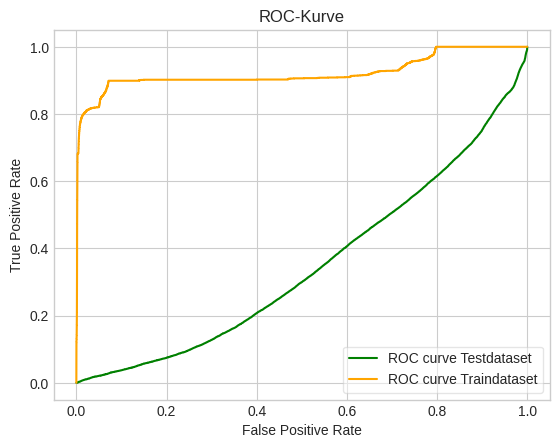

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
#Visualisierung der ROC-Kurve, um die Fähigkeit des Modells zu betrachten, die positiven und negativen Werte 
#richtig voneinander unterscheiden zu können 
fpr, tpr, _ = roc_curve(y_test,  pipe.predict_proba(X_test)[:,1])
fpr_train, tpr_train, _ = roc_curve(y_train,  pipe.predict_proba(X_train)[:,1])

plt.figure()
plt.plot(fpr,tpr,color="green",label="ROC curve Testdataset")
plt.plot(fpr_train,tpr_train,color="orange",label="ROC curve Traindataset")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Kurve")
plt.legend(loc="lower right", framealpha=0.5, frameon=True)
plt.show()

Der Testdatensatz bewegt sich grob auf der Diagonalen, was die Zuordnung eines Zufallsmodells noch verstärkt. 
Optimalerweise sollte sie sich ähnlich wie die Trainingsdatenkurve verhalten. Diese ist jedoch sogar noch schlechter
als die zufällige Zuordnung, da sie sich in die negative Richtung beugt. Es findet demnach ein starkes Overfitting statt, was sich durch die Komplexität des Modells erklären lässt. 
Es sollten regularisierende Maßnahmen oder die Reduktion der Komplexität des Modells unternommen werden. 
Es wurden Versuche unternommen das Modell mithilfe von Feature Engineering und Data Undersampling zu verbessern,
jedoch ging das dann in die Richtung von Underfitting. Außerdem wurden dem Klassifizierer das Parameter _class_weight_ = balanced übergeben. Auch andere Argumente wurden getestet, jedoch zeigte sich bei allen kein Erfolg.




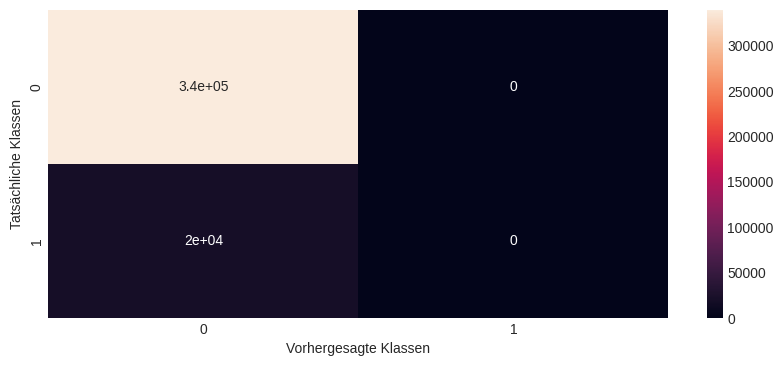

In [38]:
#Visualisierung der Konfusionsmatrix, die die Anzahl der richtig und falsch klassifizierten Klassen anzeigt
plt.figure(figsize = (10,4))
sns.heatmap(confusion_matrix(y_test, pipe.predict(X_test)), annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique())
plt.xlabel('Vorhergesagte Klassen')
plt.ylabel('Tatsächliche Klassen')
plt.show()

Die Konfusionsmatrix zeigt, dass keine einzige positive Klasse richtig klassifiziert wurde, was sogar bei einem Zufallsmodell unwahrscheinlich wäre. Das gleicht sich auch mit der ROC-Kurve.

**Visualisierung der relevanten Features** 

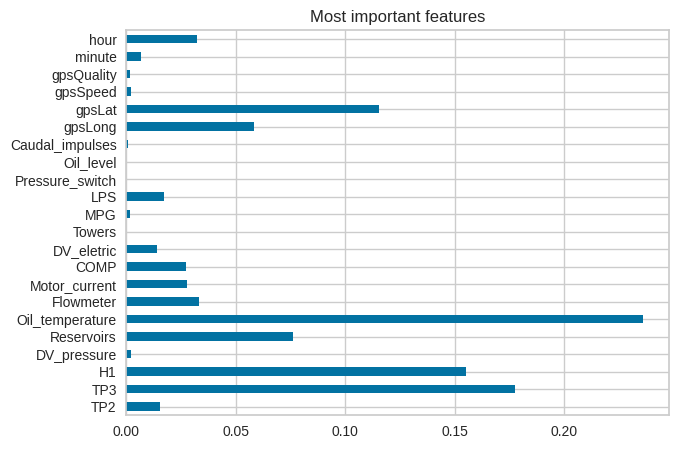

In [2152]:
#Visualisierung der wichtigsten Features des RandomForrest-Klassifikator
feat_importances = pd.Series(pipe.named_steps["clf"].feature_importances_, index=X_train.columns)
plt.figure(figsize=(7, 5))
feat_importances.plot(kind='barh')
plt.title("Most important features")
plt.tight_layout
plt.show()

Die größten Auswirkungen auf das Modell haben die numerischen Features. Dazu gehören die Öltemperatur, die Reservoirs 
und H1 und TP3. 
Überraschenderweise gehen auch die GPS-Geo-Daten stark ins Gewicht mit ein. 

## Vorhersage des Eintretens von Störungen <a class="anchor" id="chapter2"></a>

### Datenvorbereitung <a class="anchor" id="section_2_1"></a>

In [1847]:
#Entfernt gewünschten Zeitraum aus dem Datensatz
def undersampleData(X, start_time, end_time):  
    return X[~((X.index >= start_time) & (X.index <= end_time))]  

In [1]:
#Vorhersage-Zeitraum festlegen
hours = 2

In [6]:
#Originaldatensatz kopieren und eine neue Spalte mit Null-Werten füllen
df_fc = df.copy()
df_fc['forecasting'] = 0

In [67]:
#Durch die Störungsdaten iterieren und Labels für den Vorhersagezeitraum hinzufügen
for i in range(1,4):
    fails = globals()["fail%s" % i]
    df_fc.loc[fails["start"]-pd.Timedelta(hours=hours):fails["start"], "forecasting"] = 1
#Übersicht über die Zeiträume schaffen
df_fc["forecasting"].value_counts()

0    10719585
1       54003
Name: forecasting, dtype: int64

In [68]:
#Erstellen einer Liste mit verschiedenen Zeitpunkten
time_data = [('2022-01-01 18:00:00'),
            ('2022-01-12 13:00:00'), 
            ('2022-02-05 13:00:00'), 
            ('2022-02-23 16:00:00'),
            (fail1["start"]),
            ('2022-04-04 12:00:00')]
#           (fail3["start"])]


df_train = pd.DataFrame()
#Iterieren durch die Liste mit den Zeitpunkten
for end in time_data:
    #Erstellt ein temporäres DF, wo die Zeiträume zwischen Zeiträumen aus der Liste minus Stunden, die vorhergesagt
    #werden sollen und den Zeiträumen aus der Liste, welche den Endzeitpunkt dieser Zeitreihe darstellen
    df_temp = df_fc.loc[(df_fc.index >= (pd.to_datetime(end)-pd.Timedelta(hours=hours))) & (df_fc.index <= end)]
    #Verbindet die train_df mit der temporären df zusammen
    df_train = pd.concat([df_train, df_temp])

In [69]:
#Das gleiche Verfahren wie oben, nur werden hier die Testdaten erstellt
time_data_test = [('2022-01-15 12:00:00'),
                  (fail2["start"]),
                  ('2022-05-04 14:00:00')]


df_test = pd.DataFrame()
for end in time_data_test:

    df_temp = df_fc.loc[(df_fc.index >= (pd.to_datetime(end)-pd.Timedelta(hours=hours))) & (df_fc.index <= end)]
    df_test = pd.concat([df_test, df_temp])

In [ ]:
# Dadurch, dass der Datensatz in der Größe reduziert wurde, wurden mehr Features integriert, damit das Modell 
# besser die verschiedenen Muster erkennen kann
drop_list = ['fail', 'fail_type','forecasting','Pressure_switch','DV_eletric', 'Oil_level']
#Trainings- und Testdaten generieren
X_train = df_train.drop(drop_list, axis=1)
X_test = df_test.drop(drop_list, axis=1)
y_train = df_train['forecasting']
y_test = df_test['forecasting']

In [ ]:
print(f'Verteilung der Klassen in y_train \n{y_train.value_counts(normalize=True)}\n{len(y_train)}')
print(f'Verteilung der Klassen im y_test \n{y_test.value_counts(normalize=True)}\n{len(y_test)}');

### Klassifikation <a class="anchor" id="section_2_2"></a>

In [ ]:
#GridSearch Initialisierung
classifier = "rf"
grid = GridSearchCV(clfs[classifier], param_grid[classifier], scoring="accuracy")

In [ ]:
#Daten transformieren und GridSearch fitten
X_trans = preprocessor.fit_transform(X_train)
grid.fit(X_trans, y_train)

In [2120]:
#Resulate speichern
best_scores[classifier] = grid.best_score_
best_params[classifier] = grid.best_params_
print(best_scores)

{'rf': 0.8029521478102872, 'dsc': 0.8061119486862023, 'logre': 0.6749116646685496}


In [2121]:
#Die besten Parameter in den Klassifizierer einsetzen und fitten
pipe = createPipe(clfs[classifier])
pipe.named_steps["clf"].set_params(**best_params[classifier])
pipe.fit(X_train, y_train)

Pipeline(steps=[('imp', OutlierImputer()),
                ('prc',
                 Pipeline(steps=[('scl', StandardScaler()),
                                 ('pca', PCA(n_components=4))])),
                ('clf',
                 RandomForestClassifier(criterion='log_loss', max_depth=5,
                                        min_samples_split=10,
                                        n_estimators=10))])

### Bewertung des Modells <a class="anchor" id="section_2_3"></a>

In [2122]:
#Visualisierung der Metriken
print("-----Training Metriken----------")
print('Accuracy: ', pipe.score(X_train, y_train))
print('Precision: ', precision_score(y_train, pipe.predict(X_train), average = 'macro'))
print('Recall: ', recall_score(y_train, pipe.predict(X_train), average = 'macro'))
print('F1: ', f1_score(y_train, pipe.predict(X_train), average = 'macro'))
print("-----Test Metriken----------")
print('Accuracy: ', pipe.score(X_test, y_test))
print('Precision: ', precision_score(y_test, pipe.predict(X_test), average = 'macro'))
print('Recall: ', recall_score(y_test, pipe.predict(X_test), average = 'macro'))
print('F1: ', f1_score(y_test, pipe.predict(X_test), average = 'macro'))

-----Training Metriken----------
Accuracy:  0.8361508163571416
Precision:  0.8931032902585466
Recall:  0.5937265786784947
F1:  0.6117137767032842
-----Test Metriken----------
Accuracy:  0.6114089563825142
Precision:  0.7223630688113087
Recall:  0.500068104985988
F1:  0.37957201440059113


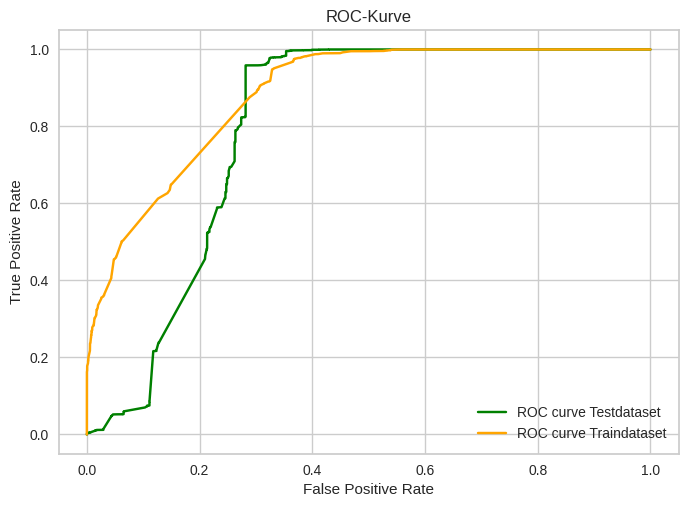

In [2123]:
#Visualisierung der ROC-Kurven
fpr, tpr, _ = roc_curve(y_test,  pipe.predict_proba(X_test)[:,1])
fpr_train, tpr_train, _ = roc_curve(y_train,  pipe.predict_proba(X_train)[:,1])

plt.figure()
plt.plot(fpr,tpr,color="green",label="ROC curve Testdataset")
plt.plot(fpr_train,tpr_train,color="orange",label="ROC curve Traindataset")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Kurve")
plt.legend(loc="lower right")
plt.show()

Es ist bei beiden ein langsamer Lernprozess sichtbar. 

In [ ]:
#Visualisierung der Konfusionsmatrix
plt.figure(figsize = (10,4))
sns.heatmap(confusion_matrix(y_test, pipe.predict(X_test)), annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique())
plt.xlabel('Vorhergesagten Klassen')
plt.ylabel('')
plt.show()

Verschiedene Zeitintervalle im Vergleich mit dem Testdaten

|Nr. 	  |  hour 	 |  acc | 	recall 	   |     f1 	   |      precision|
|---------|--------------|------------|----------------|---------------|--------|
| RFC       |	 1|	0.60   |0.50 |0.40 |	0.33|
| RFC       |	 2 |	0.66 |	0.50 |0.40 |	0.33|
| RFC      |	10|	0.60| 0.50 |0.40 |	0.52|
| LG      |	1|	0.65| 0.56 |0.56 |	0.58|
| LG     |	2|	0.66| 0.50 |0.40 |	0.33|
| LG     |	10|	0.61| 0.50 |0.37 |	0.30|
| DT    |	1|	0.45| 0.32 |0.33 |	0.32|
| DT     |	2|	0.41| 0.39 |0.39 |	0.40|
| DT     |	10|	0.35| 0.32 |0.32|	0.32|

Ergebnisse zwischen Stunde 1 und 2 unterscheiden sich nicht wirklich 

## Vorhersage der Dauer von Störungen <a class="anchor" id="chapter3"></a>

Um die Dauer der Störung vorhersagen zu können, muss zuerst ein kontinuierlicher Referenzwert für die Regression geschaffen werden. Dabei werden die zeitlichen Differenzen innerhalb jeder Störung berechnet, indem der Zeitpunkt des Störung-Endes mit jedem Sample innerhalb des Störungszeitraums subtrahiert wird. Die zeitliche Differenz wird in der Spalte "tune_diff" gespeichert und dient als Label für die Regression.

### Datenvorbereitung <a class="anchor" id="section_3_1"></a>

In [34]:
from sklearn.ensemble import RandomForestRegressor

# Datensatz erstellen, der speziell für die Regressionsaufgabe dient
df_reg = df.copy()
# Nur die Daten mit Fehlern verwenden, da Daten ohne Fehler nicht von Interesse für die Berechnung der Dauer der Störung sind
df_reg = df_reg[df_reg['fail_type'] != 0]
# Zeitliche Differenz berechnen für jeden Fehlertyp, im Bezug zum aktuellen Punkt und Endpunkt der jeweiligen Störung
n_fail_types = 3
df_diff = pd.DataFrame()

for i in range(n_fail_types):
    # Zeilen mit entsprechendem Fehlertyp auswählen
    fail = df_reg[df_reg['fail_type'] == i+1]
    # Zeitliche Differenz berechnen
    df_temp = (fail.index.to_series()[-1] - fail.index.to_series()).astype('timedelta64[m]')
    # Berechneten Werte zusammenfügen
    df_diff = pd.concat([df_diff, df_temp])

# Spalte umbenennen
df_diff.set_axis(['time_diff'], axis=1, inplace=True)
# Mit gesamten Datensatz für Regression konkatenieren
df_reg = pd.concat([df_reg, df_diff], axis=1, ignore_index=False)


/tmp/ipykernel_371927/3660287381.py:20: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_diff.set_axis(['time_diff'], axis=1, inplace=True)


In [35]:
drop_list = ['fail', 'fail_type','Pressure_switch','DV_eletric', 'Oil_level', 'gpsLat', 'COMP']
# TimeSeriesSplit nutzen, um Zeitabfolgen zu bewahren
tms = TimeSeriesSplit(n_splits=2)
X = df_reg.drop(drop_list, axis=1)
y = df_reg['time_diff']
for train_idx, test_idx in tms.split(X):
    X_train, X_test  = X.iloc[train_idx, :], X.iloc[test_idx,:]
    y_train, y_test  = y.iloc[train_idx], y.iloc[test_idx]

### Regression <a class="anchor" id="section_3_2"></a>

In [26]:
clf_reg = RandomForestRegressor()
pipe_reg = createPipe(clf_reg)
grid = GridSearchCV(clf_reg, param_grid["rfreg"], scoring="accuracy")

In [ ]:
#Daten transformieren und GridSearch fitten
X_trans = preprocessor.fit_transform(X_train)
grid.fit(X_trans, y_train)

In [ ]:
#Resulate speichern
best_scores["rfreg"] = grid.best_score_
best_params["rfreg"] = grid.best_params_
print(best_scores)

In [36]:
pipe_reg = createPipe(clf_reg)
#pipe_reg.named_steps["clf"].set_params(**best_params["rfreg"])
pipe_reg.fit(X_train, y_train)

Pipeline(steps=[('imp', OutlierImputer()),
                ('prc',
                 Pipeline(steps=[('scl', StandardScaler()), ('pca', PCA())])),
                ('clf', RandomForestRegressor())])

### Bewertung des Modells <a class="anchor" id="section_3_3"></a>

In [ ]:
#Visualisierung der Metriken
print("-----Training Metriken----------")
print('Accuracy: ', pipe_reg.score(X_train, y_train))
print("-----Test Metriken----------")
print('Accuracy: ', pipe_reg.score(X_test, y_test))

## Vorhersage der gestörten Komponente <a class="anchor" id="chapter4"></a>

### Datenvorbereitung <a class="anchor" id="section_4_1"></a>

In [2175]:
#Erstellung eines neuen Datensatzes, der nur die Störungen beinhaltet
df_fail = df.loc[df['fail']==1]

In [1747]:
fail3

{'start': Timestamp('2022-05-30 12:00:00'),
 'end': Timestamp('2022-06-02 06:18:00'),
 'component': 3}

Da die Daten mit TimeSeriesSplit nicht gleichmäßig geteilt werden können, weil der letzte Testdatensatz 
immer propotional mehr Störungsdaten aus der letzten Klasse beinhaltet, wurde sich dazu entschieden, die Klassen 
gleichmäßig untereinander aufzuteilen. Hierfür wurde als Orientierung die kleinste Klasse mit einem Zeitintervall von 30 Minuten genommen. Die ersten 25 Minuten jeder Störung wurden dem Trainingsdatensatz zugewiesen, während die verbleibenden 5 Minuten dem Testdatensatz zugewiesen wurden. Diese Vorgehensweise soll sicherstellen, dass das Modell beim Training ausreichend Daten unterschiedlicher Klassen erhält und auch im Testdatensatz in der Lage ist, die verschiedenen Klassen voneinander zu unterscheiden.

In [2179]:
df_train1 = df_fail[((df_fail.index >= '2022-02-28 21:53:00') & (df_fail.index <= '2022-02-28 22:18:00'))]
df_train2 = df_fail[((df_fail.index >= '2022-03-23 14:54:00') & (df_fail.index <= '2022-03-23 15:19:00'))]
df_train3 = df_fail[((df_fail.index >= '2022-05-30 12:00:00') & (df_fail.index <= '2022-05-30 12:25:00'))]

df_train = pd.concat([df_train1,df_train2,df_train3])

In [2180]:
df_test1 = df_fail[((df_fail.index >= '2022-02-28 22:18:01') & (df_fail.index <= '2022-02-28 22:23:00'))]
df_test2 = df_fail[((df_fail.index >= '2022-03-23 15:19:01') & (df_fail.index <= '2022-03-23 15:24:00'))]
df_test3 = df_fail[((df_fail.index >= '2022-05-30 12:25:01') & (df_fail.index <= '2022-05-30 12:30:00'))]

df_test = pd.concat([df_test1,df_test2,df_test3])

Um die Klassen richtig zu klassifizieren, werden die Features einbezogen, die in der ersten Aufgabe als nicht geeignet deklariert worden sind, denn hier sind z.B. die einzelnen Ausschläge in bei der ersten Störung wichtiger, da besonders die erste und zweite Klasse sich von der Störung gleichen und jeder Unterschied zwischen diesen beiden von Bedeutung sein könnte. Außerdem werden die GPS-Daten mit einbezogen, denn diese weichen stark von den ersten beiden Klassen ab. 

In [2181]:
#LPS kommt wieder rein, wie bereits oben beschrieben, genau wie Caudal_impulses, auch die GPS Daten, Flowmeter, Towers
drop_list = ['fail', 'fail_type','Pressure_switch','DV_eletric', 'Oil_level', 'gpsLat', 'COMP']

X_train = df_train.drop(drop_list, axis=1)
X_test = df_test.drop(drop_list, axis=1)
y_train = df_train['fail_type']
y_test = df_test['fail_type']

In [2182]:
print(f'Verteilung der Klassen in y_train \n{y_train.value_counts(normalize=True)}\n{len(y_train)}')
print(f'Verteilung der Klassen im y_test \n{y_test.value_counts(normalize=True)}\n{len(y_test)}');

Verteilung der Klassen in y_train 
1    0.333333
2    0.333333
3    0.333333
Name: fail_type, dtype: float64
4503
Verteilung der Klassen im y_test 
1    0.333333
2    0.333333
3    0.333333
Name: fail_type, dtype: float64
900


### Multiclass Klassifikation <a class="anchor" id="section_4_2"></a>

In [1833]:
#GridSearch Initialisierung
classifier = "logre"
grid = GridSearchCV(clfs[classifier], param_grid[classifier], scoring="accuracy")

In [ ]:
#Daten transformieren und GridSearch fitten
X_trans = preprocessor.fit_transform(X_train)
grid.fit(X_trans, y_train)

In [1835]:
#Resulate speichern
best_scores[classifier] = grid.best_score_
best_params[classifier] = grid.best_params_
print(best_scores)

{'rf': 0.9013528178567025, 'dsc': 0.8840377358490565, 'logre': 0.8544945122703169}


In [ ]:
#Die besten Parameter in den Klassifizierer einsetzen und fitten
pipe = createPipe(clfs[classifier])
pipe.named_steps["clf"].set_params(**best_params[classifier])
pipe.fit(X_train, y_train)

### Bewertung des Modells <a class="anchor" id="section_4_3"></a>

In [1844]:
#Visualisierung der Metriken
print("-----Training Metriken----------")
print('Accuracy: ', pipe.score(X_train, y_train))
print('Precision: ', precision_score(y_train, pipe.predict(X_train), average = 'macro'))

print("-----Test Metriken----------")
print('Accuracy: ', pipe.score(X_test, y_test))
print('Precision: ', precision_score(y_test, pipe.predict(X_test), average = 'macro'))

-----Training Metriken----------
Accuracy:  0.8363313346657784
Precision:  0.8368771714840068
-----Test Metriken----------
Accuracy:  0.8566666666666667
Precision:  0.8997668997668997


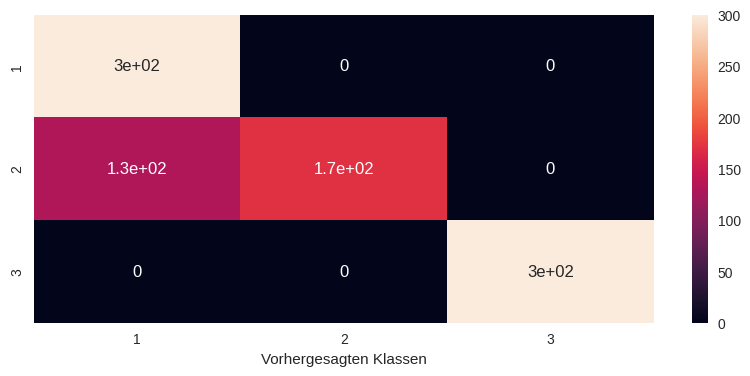

In [1845]:
#Visualisierung der Konfusionsmatrix
plt.figure(figsize = (10,4))
sns.heatmap(confusion_matrix(y_test, pipe.predict(X_test)), annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique())
plt.xlabel('Vorhergesagten Klassen')
plt.ylabel('')
plt.show()

Die erste und die dritte Klassen können sehr gut erkannt und als diese klassifiziert werden. Dies liegt vor allem an ihren markanteren Merkmalen, welche bereits oben analysiert wurden. Die zweite Klasse wird jedoch auch des Öfteren als die erste klassifiziert. Dies könnte an der Tatsache liegen, dass beide Fehler der Kategorie 'Airleak' angehören.

In [1839]:
#Weiterer Test des Klassifikators
df_test4 = df_fail[((df_fail.index >= '2022-03-01 00:00:00') & (df_fail.index <= '2022-03-01 02:00:00'))]
X_test4 = df_test4.drop(drop_list, axis=1)
y_test4 = df_test4['fail_type']

In [1841]:
pipe.score(X_test4,y_test4)

0.9047354534092488

## Clustering

Für das Unsupervised Learning wurde ein K-means-Modell gewählt. Es wurde mit zwei Clustern initialisiert, da die Ellenbogen-Methode einen deutlichen Knick bei der Anzahl von zwei Clustern zeigte. Die Methode gibt einen groben Anhaltspunkt fur die Anzahl der Cluster, indem sie eine bestimmte Anzahl von Clustergrößen testet und fur jede Clustergröße die Summe der quadrierten Abstände bestimmt. Diese wird durch den Abstand jedes einelnen Punktes zum Clusterzentrum bestimmt. Nun wird der Punkt ermittelt, bei denen die Abstände zum Mittelpunkt möglichst gering sind, genauso wie die Anzahl der Cluster.

In [61]:
from sklearn.cluster import KMeans
kms_clf = KMeans(n_clusters=2, n_init=10, random_state=2)
cluster_pipe = createPipe(kms_clf)
X = cluster_pipe.fit(X_train)
y_pred = cluster_pipe.predict(X_train)

Um die Güte der Cluster zu bewerten, wird der Silhouetten-Score berechnet. Dieser funktioniert im Groben
so, dass er misst, wie gut das Objekt in seinem Cluster passt, im Vergleich zu anderen Clustern. Dabei
werden die anderen Objekte im Cluster zum Vergleich genommen. Die Werte reichen von -1 bis 1

In [62]:
from sklearn.metrics import silhouette_score
print(f'Silhouette Score: {silhouette_score(X_train, y_pred)}')

"from sklearn.metrics import silhouette_score\nprint(f'Silhouette Score: {silhouette_score(X_train, y_pred)}')"

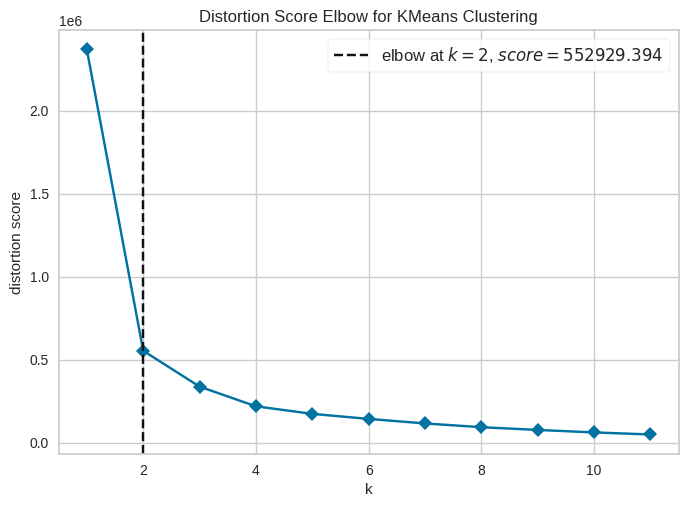

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [1817]:
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(kms_clf, k=(1,12), timings=False)
visualizer.fit(X_train)
visualizer.show()

In [59]:
#Visualisierung der Cluster als ScatterPlot
Sc = StandardScaler()
X = Sc.fit_transform(df_tr)
#Reduzieren die X-Daten in 2D, um sie besser visualisieren zu können
pca2 = PCA(2).fit_transform(X) 
pca2 = pd.DataFrame(pca2, columns=['x1','x2'])

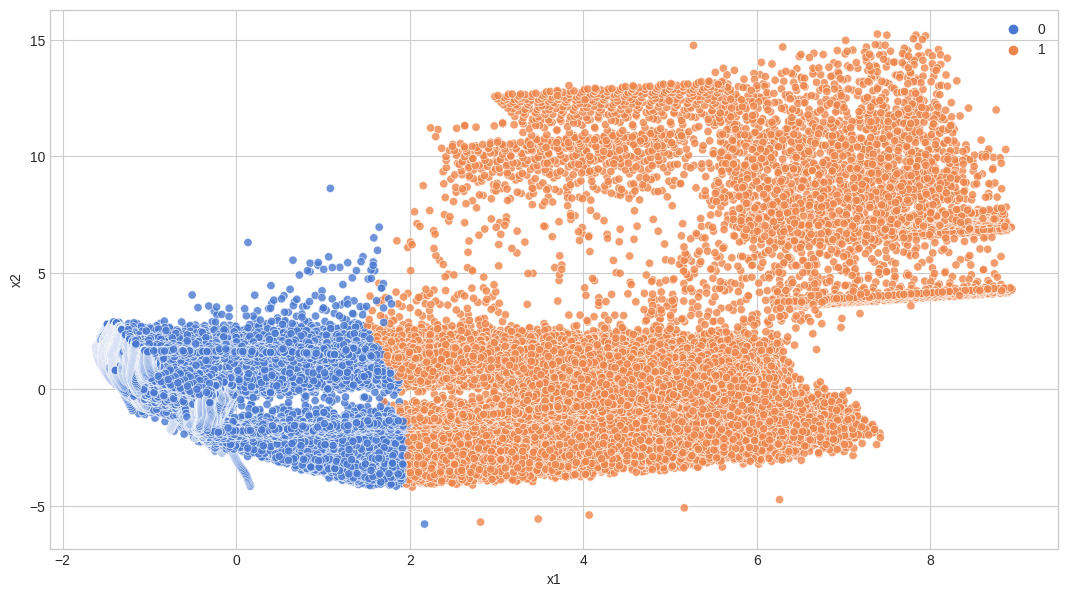

In [58]:
plt.figure(figsize=(13,7))
sns.scatterplot(x='x1',y='x2', data=pca2, hue=y_pred,  palette='muted', alpha=0.8)
plt.show()

## Quellen

[1] Veloso, B., Ribeiro, R.P., Gama, J. et al. The MetroPT dataset for predictive maintenance. Sci Data 9, 764 (2022). https://doi.org/10.1038/s41597-022-01877-3
